In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import pandas as pd


Bad key "text.kerning_factor" on line 4 in
/home/sam/miniconda3/envs/bayes/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

plt.rcParams['figure.figsize'] = [5.0, 4.0]
plt.rcParams["font.size"] = 14
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.5
plt.rcParams['axes.facecolor'] = 'white'

In [4]:
# code 5.1
d = pd.read_csv("./data/WaffleDivorce.csv", delimiter=";")

print(d.MedianAgeMarriage.std())

d["A"] = (d.MedianAgeMarriage - d.MedianAgeMarriage.mean()) / d.MedianAgeMarriage.std()
d["D"] = (d.Divorce - d.Divorce.mean()) / d.Divorce.std()

d.head()

1.2436303013880823


,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,A,D
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.606290,1.654205
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.686699,1.544364
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,-0.204241,0.610716
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,-1.410387,2.093569
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,0.599857,-0.927058


In [63]:
with pm.Model() as m5_1:
    
    a = pm.Normal("a", mu=0, sigma=0.2)
    Ba = pm.Normal("Ba", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + Ba*d.A)
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=d.D)
    
    trace5_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Ba, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


/home/sam/miniconda3/envs/bayes/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


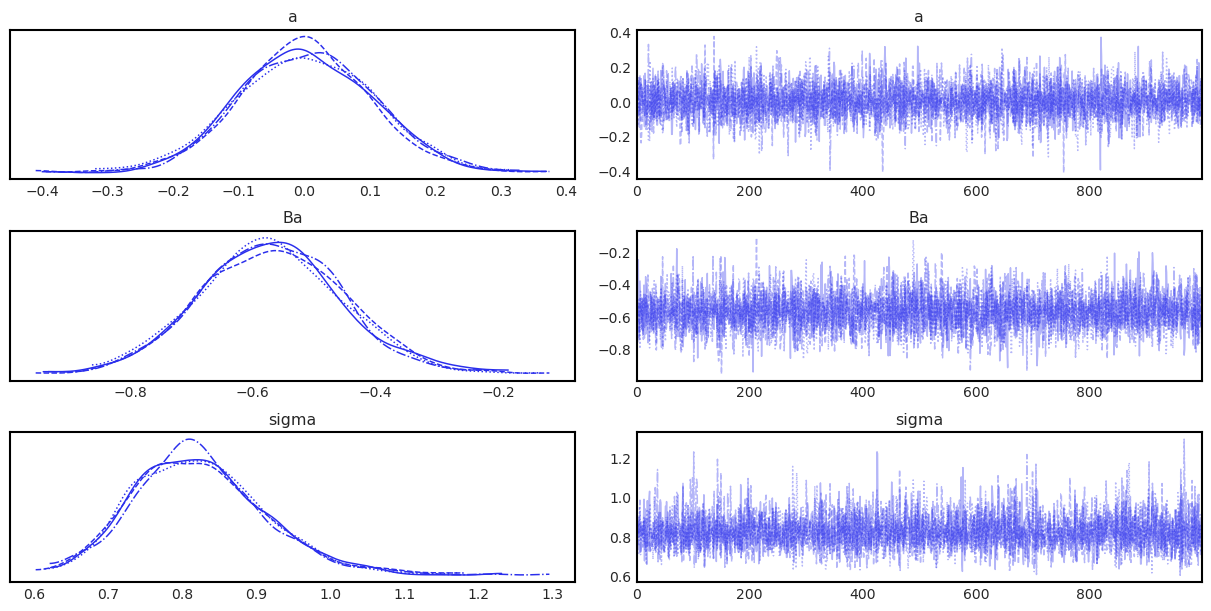

In [64]:
varnames=["~mu"]
az.plot_trace(trace5_1, varnames);
plt.show()

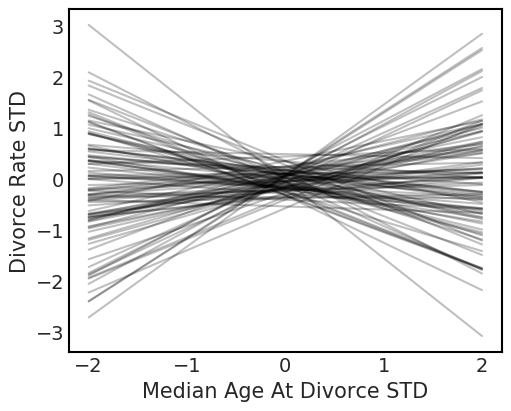

In [65]:
with m5_1 as model:
    pp = pm.sample_prior_predictive(1000)
    
x = np.linspace(-2,2,100)

for a, Ba in zip(pp["a"][:100], pp["Ba"][:100]):
    plt.plot(x, a + Ba*x, "k", alpha=0.25)
    
plt.xlabel("Median Age At Divorce STD")
plt.ylabel("Divorce Rate STD")
plt.show()

/home/sam/miniconda3/envs/bayes/lib/python3.7/site-packages/arviz/stats/stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


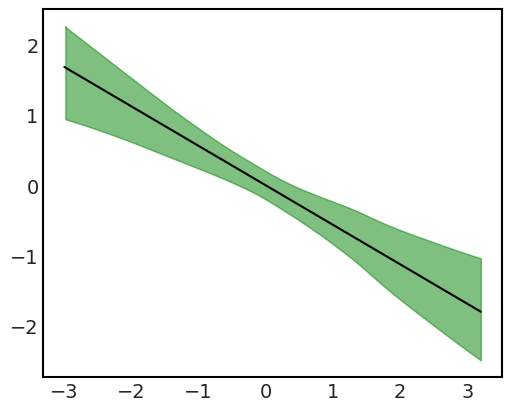

In [71]:
A_seq = np.linspace(-3, 3.2, 30)

trace5_1_cut = trace5_1[::10]
mu_pred = np.zeros((len(A_seq), len(trace5_1_cut) * trace5_1.nchains))
for i, age in enumerate(A_seq):
    mu_pred[i] = trace5_1_cut["a"] + trace5_1_cut["Ba"] * age

mum = mu_pred.mean(axis=1)

az.plot_hdi(A_seq, mu_pred.T, color="g")
plt.plot(A_seq, mum, "k")
plt.show()

In [74]:
d["M"] = (d.Marriage - d.Marriage.mean()) / d.Marriage.std()

with pm.Model() as m5_2:
    a = pm.Normal("a", mu=0, sd=0.2)
    Bm = pm.Normal("Bm", mu=0, sd=0.5)
    sigma = pm.Exponential("sigma", 1)
    
    mu = pm.Deterministic("mu", a + Bm*d.M)
    
    D = pm.Normal("D", mu=mu, sd=sigma, observed=d.D)
    
    trace5_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Bm, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


/home/sam/miniconda3/envs/bayes/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


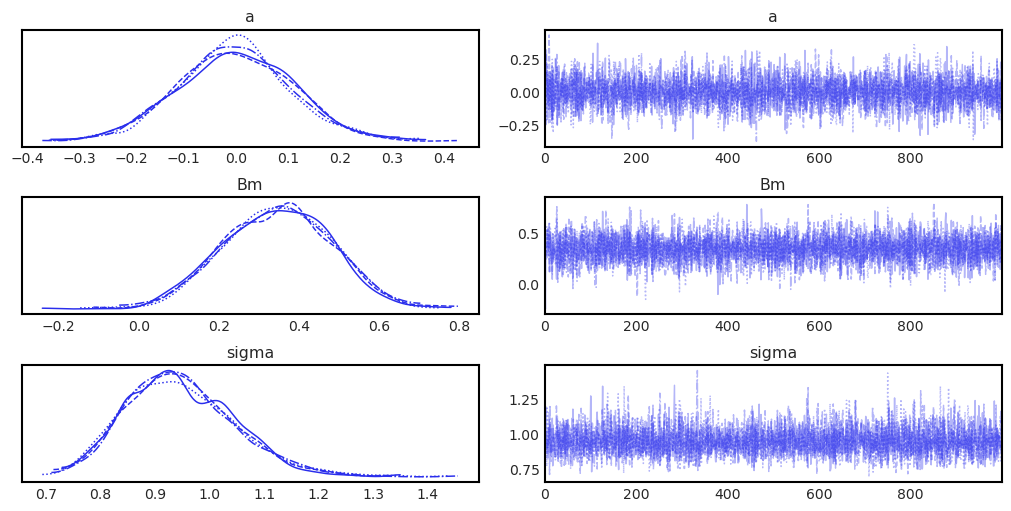

In [80]:
varnames = ["~mu"]
az.plot_trace(trace5_2, varnames, figsize=(10,5))
plt.show()

In [8]:
with pm.Model() as m5_3:
    a = pm.Normal("a", mu=0, sd=0.2)
    bM = pm.Normal("bM", mu=0, sd=0.5)
    bA = pm.Normal("bA", mu=0, sd=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bM*d.M + bA*d.A)
    D = pm.Normal("D", mu=mu, sd=sigma, observed=d.D)
    
    trace5_3 = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, bM, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


In [92]:
varnames = ["~mu"]
az.summary(trace5_3, varnames)

/home/sam/miniconda3/envs/bayes/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.000,0.101,-0.183,0.190,0.001,0.001,6925.0,4464.0,6942.0,6043.0,1.0
bM,-0.061,0.159,-0.362,0.229,0.002,0.002,4720.0,4578.0,4724.0,5331.0,1.0
bA,-0.608,0.160,-0.912,-0.313,0.002,0.002,4619.0,4593.0,4620.0,5391.0,1.0
sigma,0.826,0.086,0.678,0.999,0.001,0.001,6070.0,6053.0,6044.0,4966.0,1.0


/home/sam/miniconda3/envs/bayes/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


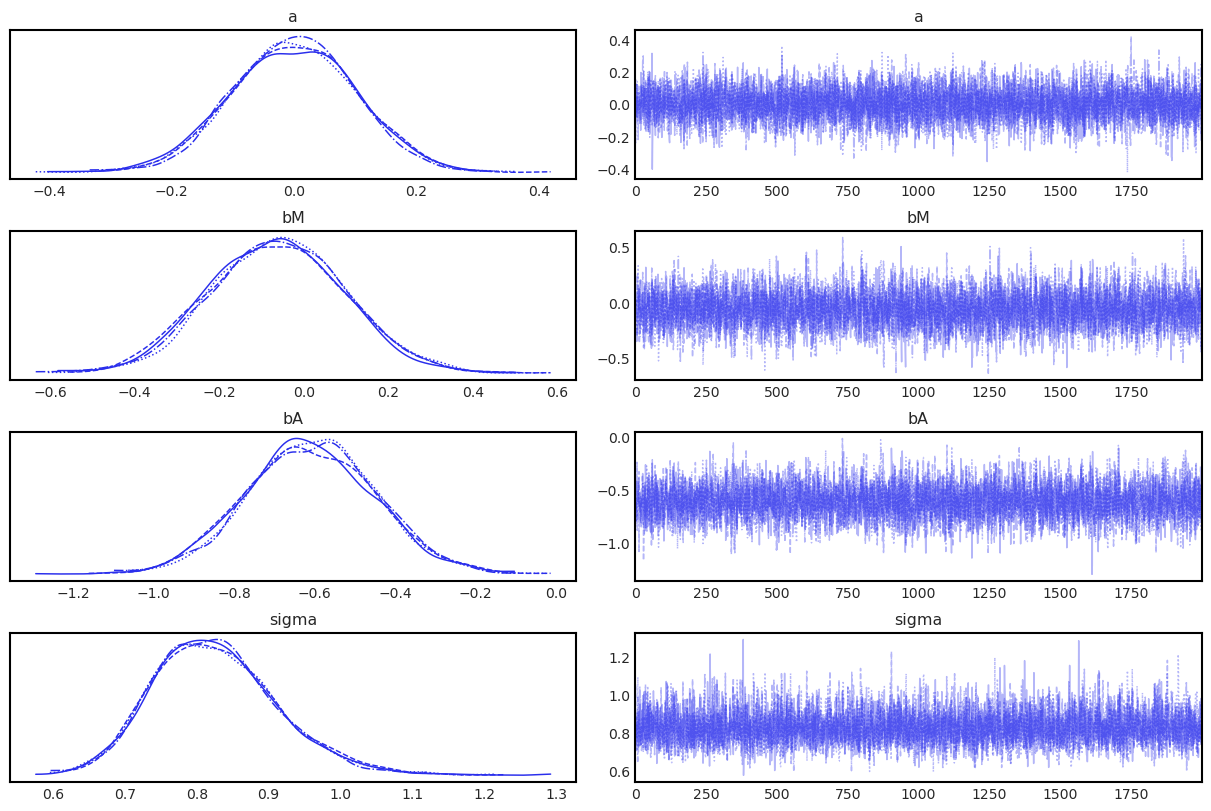

In [93]:
az.plot_trace(trace5_3, varnames)
plt.show()

In [95]:
# predictor residual plots
# code 5.13
# First, predicting marriage rate based on age

with pm.Model() as m5_4:
    a = pm.Normal("a", mu=0, sd=0.2)
    b = pm.Normal("b", mu=0, sd=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + b*d.A)
    M = pm.Normal("M", mu=mu, sd=sigma, observed = d.M)
    
    trace5_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [152]:
residualsM = d.M - (trace5_4["a"].mean() + trace5_4["b"].mean()*d.A)

# Now model D based on marriage rate residuals 
with pm.Model() as m5_5:
    a = pm.Normal("a", mu=0, sd=0.2)
    b = pm.Normal("b", mu=0, sd=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + b*residualsM)
    M = pm.Normal("M", mu=mu, sd=sigma, observed = d.D)
    
    trace5_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


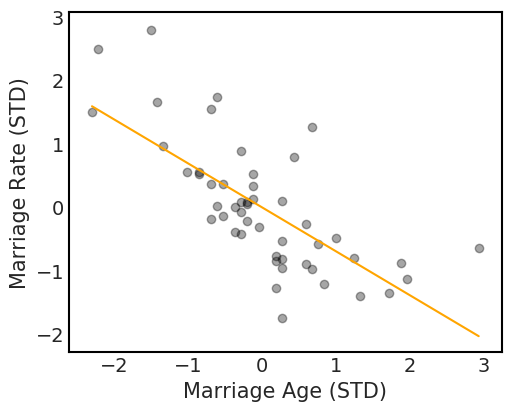

In [153]:
x = np.linspace(d.A.min(), d.A.max(), 50)

plt.plot(x, trace5_4["a"].mean() + trace5_4["b"].mean()*x, "orange")
plt.scatter(d.A, d.M, color="k", alpha=0.35)
plt.xlabel("Marriage Age (STD)")
plt.ylabel("Marriage Rate (STD)")
plt.show()
# Here, residuals can be eyeballed (difference empirical data and mean prediction)

/home/sam/miniconda3/envs/bayes/lib/python3.7/site-packages/arviz/stats/stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


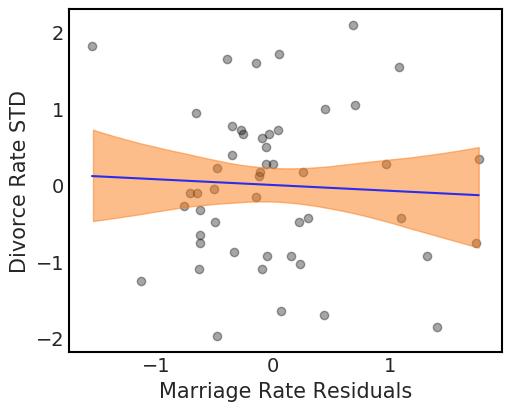

In [156]:
# Now we can see if theres any relationship between marriage rate residuals and divorce rate.
D_pred = np.zeros((len(x), len(trace5_5)*trace5_5.nchains))
for i, rate in enumerate(x):
    D_pred[i] = trace5_5["a"] + trace5_5["b"] * rate

x = np.linspace(residualsM.min(), residualsM.max(), 50)
plt.plot(x, D_pred.mean(axis=1))
plt.scatter(residualsM, d.D, color="k", alpha=0.35)
az.plot_hdi(x, D_pred.T)
plt.xlabel("Marriage Rate Residuals")
plt.ylabel("Divorce Rate STD")
plt.show()
# There appears to be no real relationship. Thus, once we account for the effect of marriage age on marriage rate, 
# marriage rate doesn't tell us much about divorce rates. "If we know marriage age, then marriage rate doesnt tell us much about divorce"

# See book for different story when we account for effect of marriage rate on marriage age. "If we know marriage rate, then marriage age DOES tell us something about divorce rates"

In [37]:
# code 5.15
d["M"] = (d.Marriage - d.Marriage.mean()) / d.Marriage.std()
print(len(d))
# We want to simulate divorce rates based on a states marriage age and marriage rate.
D_samples = np.zeros((len(d), trace5_3.nchains*len(trace5_3)))
D_hdi = np.zeros((len(d), 2))
for i in range(len(d)):
    D_samples[i, :] = trace5_3["a"] + d["M"][i]*trace5_3["bM"] + d["A"][i]*trace5_3["bA"]
    temp =  az.hdi(D_samples[i,:], hdi_prob=0.89)
    D_hdi[i, 0] = np.abs(D_samples[i,:].mean() - temp[0])

50


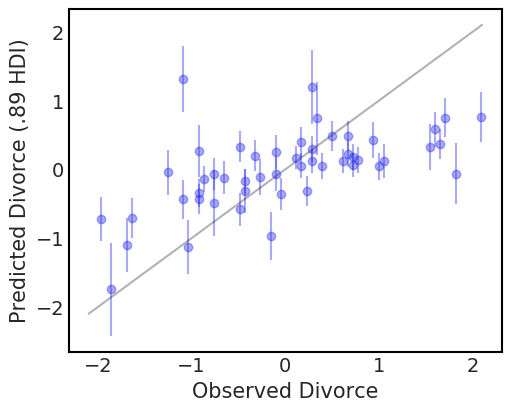

In [50]:
#plt.scatter(d.D, D_samples.mean(axis=1),yerr=0)

plt.errorbar(d.D, D_samples.mean(axis=1),yerr=D_hdi[:,0], fmt="o", alpha=0.4)
plt.plot(np.linspace(-2.1, 2.1, 100), np.linspace(-2.1, 2.1, 100), color="k", alpha=0.3)
plt.xlabel("Observed Divorce")
plt.ylabel("Predicted Divorce (.89 HDI)")
plt.show()

In [67]:
# code 5.19 - version one
with pm.Model() as m5_4a: # A->D<-M
    a = pm.Normal("a", mu=0, sd=0.2)
    bM = pm.Normal("bM", mu=0, sd=0.5)
    bA = pm.Normal("bA", mu=0, sd=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bM*d.M + bA*d.A)
    D = pm.Normal("D", mu=mu, sd=sigma, observed=d.D)
    
    trace5_4a = pm.sample()
    
with pm.Model() as m5_4b: # A->M
    a = pm.Normal("a", mu=0, sd=0.2)
    bA = pm.Normal("bA", mu=0, sd=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bA*d.A)
    M = pm.Normal("M", mu=mu, sd=sigma, observed=d.M)
    
    trace5_4b = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, bM, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


/home/sam/miniconda3/envs/bayes/lib/python3.7/site-packages/arviz/stats/stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


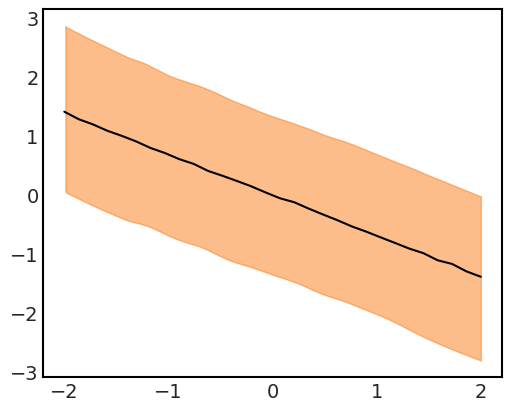

In [110]:
A_seq = np.linspace(-2, 2, 30)

# Simulate both M and then D: We have to simulate the influence of A on M before the simulate the joint influence
# of A and M on D.

M_sim = np.zeros((30, len(trace5_4b)*trace5_4b.nchains))
D_sim = np.zeros((30, len(trace5_4b)*trace5_4b.nchains))
# Simulate A->M
for i in range(len(A_seq)):
    M_sim[i,:] = trace5_4b["a"] + trace5_4b["bA"]*A_seq[i]
    D_sim[i,:] = trace5_4a["a"] + trace5_4a["bA"]*A_seq[i] + trace5_4a["bM"]*M_sim[i,:].mean()
    
A_seq = np.linspace(-2, 2, 30)

for i in range(len(A_seq)):
    M_sim[i,:] = np.random.normal(trace5_4b["a"] + trace5_4b["bA"]*A_seq[i], scale=trace5_4b["sigma"])
az.plot_hdi(A_seq, M_sim.T)
plt.plot(A_seq, M_sim.mean(1), "k")
plt.show()


In [76]:
# code 5.19 - version 2
from theano import shared

marriage_shared = shared(d["M"].values)
age_shared = shared(d["A"].values)

with pm.Model() as m5_3_A:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bA * age_shared + bM * marriage_shared)
    divorce = pm.Normal("divorce", mu, sigma, observed=d.D)

    # A -> M
    sigma_M = pm.Exponential("sigma_m", 1)
    bAM = pm.Normal("bAM", 0, 0.5)
    aM = pm.Normal("aM", 0, 0.2)
    mu_M = pm.Deterministic("mu_m", aM + bAM * age_shared)
    marriage = pm.Normal("marriage", mu_M, sigma_M, observed=d.M)

    m5_3_A_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [aM, bAM, sigma_m, a, bM, bA, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


/home/sam/miniconda3/envs/bayes/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


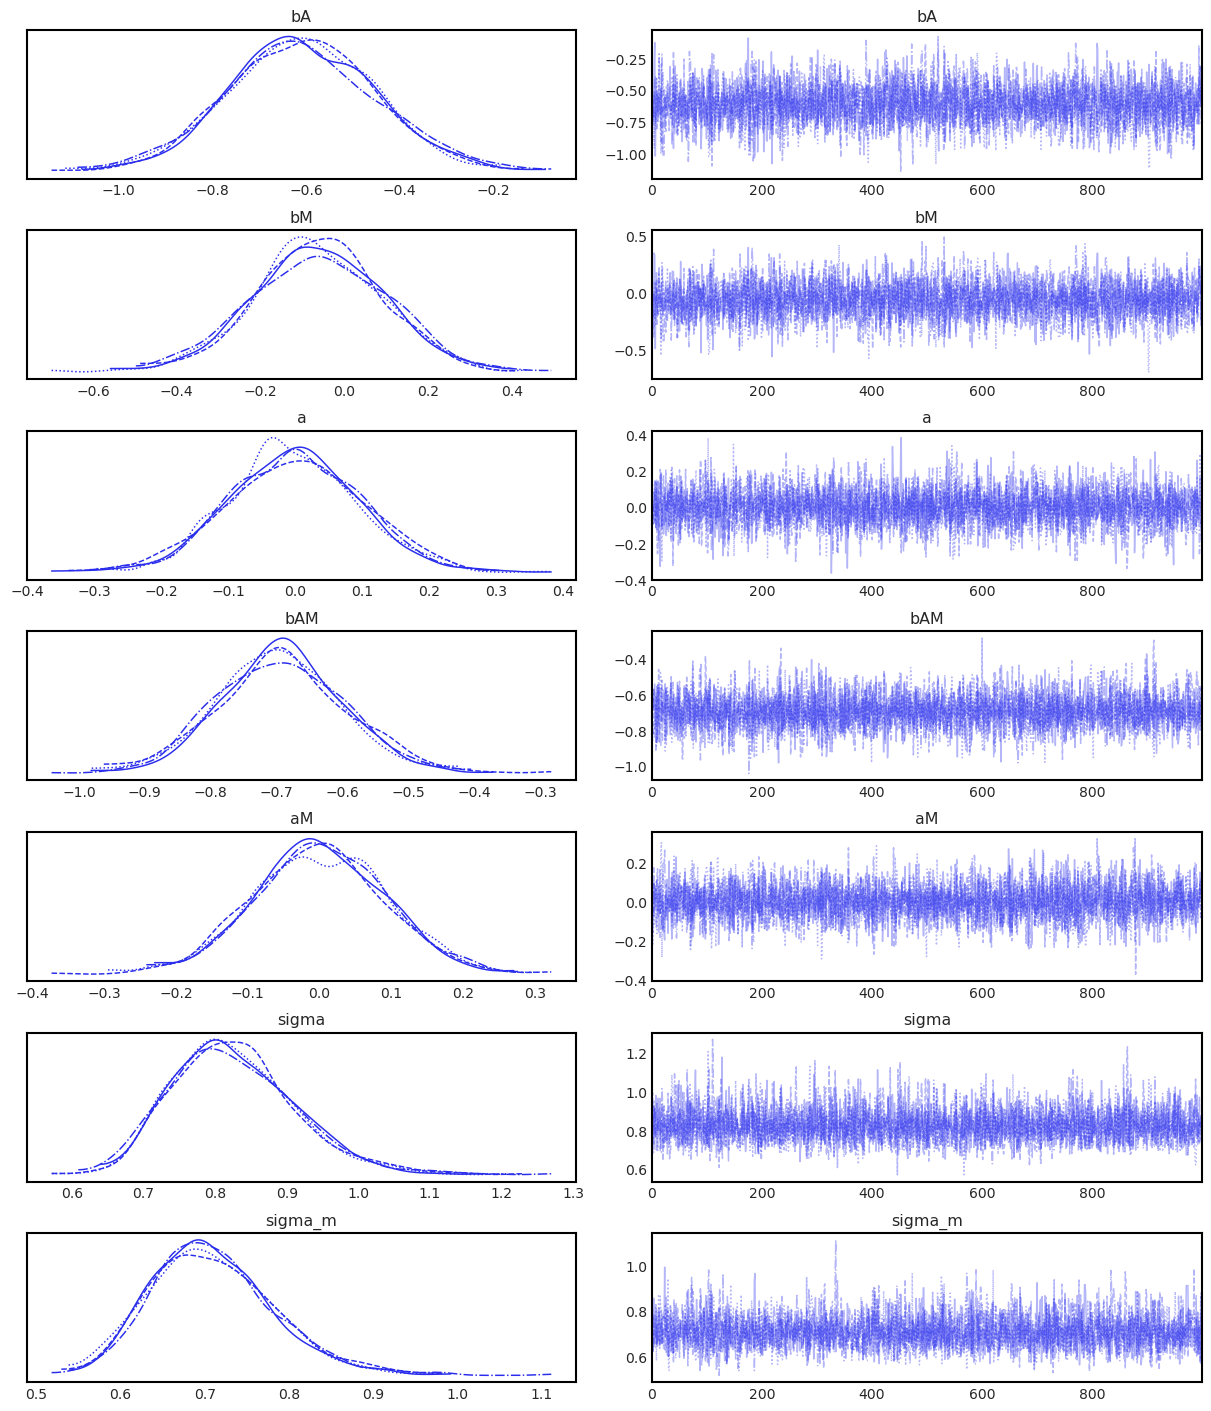

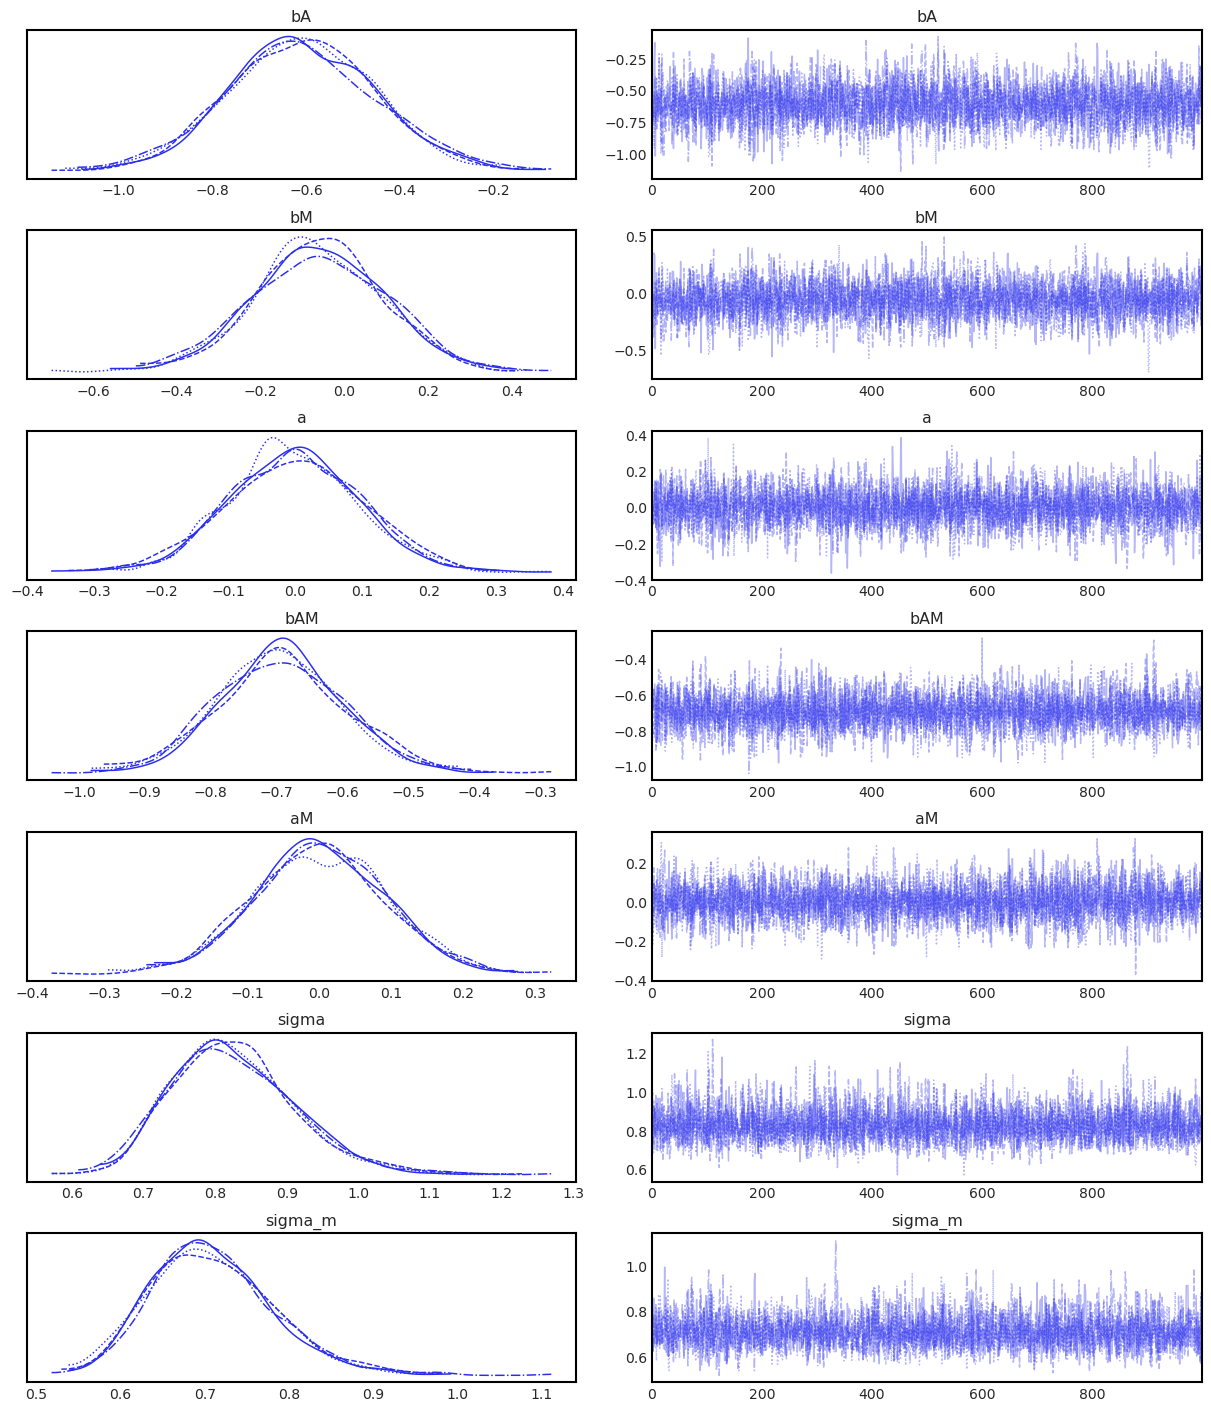

In [81]:
az.plot_trace(m5_3_A_trace, ["~mu", "~mu_m"])
plt.show()

In [83]:
A_seq = np.linspace(-2, 2, 50)
age_shared.set_value(A_seq)

with m5_3_A:
    m5_3_M_marriage = pm.sample_posterior_predictive(m5_3_A_trace)

/home/sam/miniconda3/envs/bayes/lib/python3.7/site-packages/arviz/stats/stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,
/home/sam/miniconda3/envs/bayes/lib/python3.7/site-packages/arviz/stats/stats.py:496: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


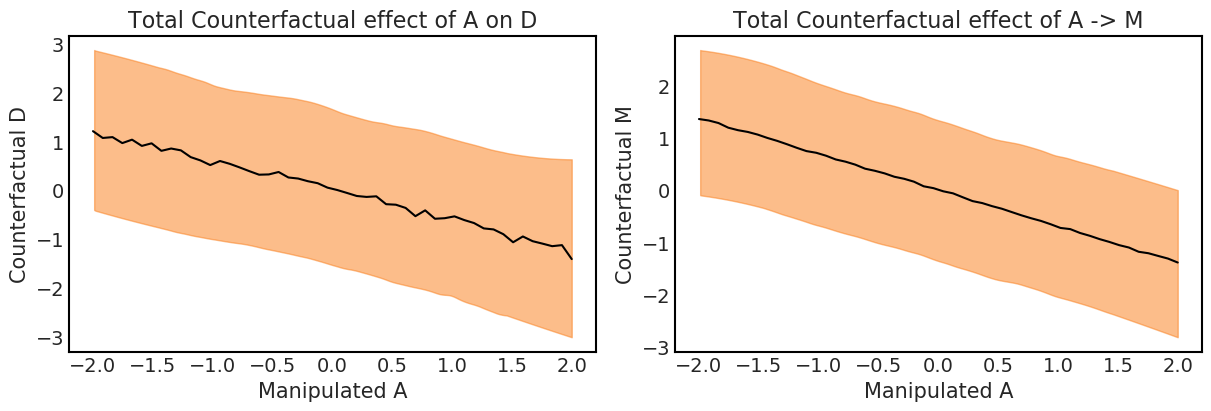

In [87]:
m5_3_M_marriage
_, ax = plt.subplots(1, 2, figsize=(12, 4))
az.plot_hdi(A_seq, m5_3_M_marriage["divorce"], ax=ax[0])
ax[0].plot(A_seq, m5_3_M_marriage["divorce"].mean(0), "k")
ax[0].set_title("Total Counterfactual effect of A on D")
ax[0].set_xlabel("Manipulated A")
ax[0].set_ylabel("Counterfactual D")

az.plot_hdi(A_seq, m5_3_M_marriage["marriage"], ax=ax[1])
ax[1].plot(A_seq, m5_3_M_marriage["marriage"].mean(0), "k")
ax[1].set_title("Total Counterfactual effect of A -> M")
ax[1].set_xlabel("Manipulated A")
ax[1].set_ylabel("Counterfactual M");a

plt.show()
# By 'manipulating' (fixing) a parameter, for example A, one breaks effect ONTO that example (eg M->A, simply because we set A and
# thus no other influence on it is exerted)

In [114]:
d = pd.read_csv("./data/milk.csv", delimiter=";")
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [121]:
d["K"] = (d["kcal.per.g"] - d["kcal.per.g"].mean() ) / d["kcal.per.g"].std()
d["N"] = (d["neocortex.perc"] - d["neocortex.perc"].mean() ) / d["neocortex.perc"].std()
d["M"] = (np.log(d.mass) - np.log(d.mass).mean() ) / np.log(d.mass).std()

In [122]:
dcc = d.dropna(axis=0)
dcc.shape

(17, 11)

In [124]:
# code 5.32 ++
with pm.Model() as m5_6:
    a = pm.Normal("a", 0, 1)
    bN = pm.Normal("bN", 0, 1)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bN*dcc.N)
    K = pm.Normal("K", mu, sigma, observed=dcc.K)

    trace5_6 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


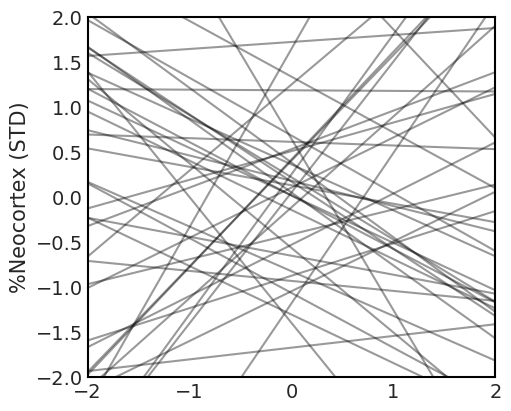

In [157]:
with m5_6 as model:
    pp = pm.sample_prior_predictive(1000)
    
x = np.linspace(-2,2,100)
for a, bN in zip(pp["a"][::25], pp["bN"][::25]):
    plt.plot(x, a + bN*x, c="k", alpha=0.4)
plt.ylim([-2, 2])
plt.xlim([-2, 2])
plt.ylabel("Kcal / Kg (STD)")
plt.ylabel("%Neocortex (STD)")

plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


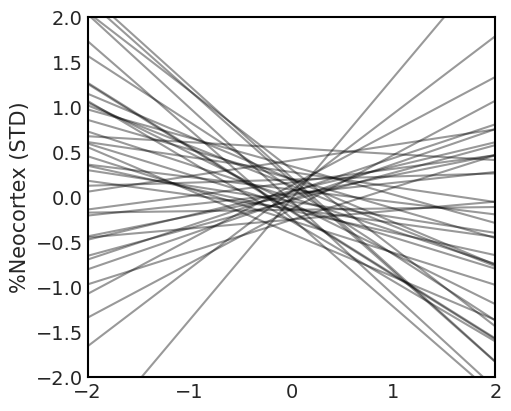

In [159]:
with pm.Model() as m5_6b:
    a = pm.Normal("a", 0, 0.2)
    bN = pm.Normal("bN", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bN*dcc.N)
    K = pm.Normal("K", mu, sigma, observed=dcc.K)

    trace5_6b = pm.sample()
    
with m5_6b as model:
    pp = pm.sample_prior_predictive(1000)
    
x = np.linspace(-2,2,100)
for a, bN in zip(pp["a"][::25], pp["bN"][::25]):
    plt.plot(x, a + bN*x, c="k", alpha=0.4)
plt.ylim([-2, 2])
plt.xlim([-2, 2])
plt.ylabel("Kcal / Kg (STD)")
plt.ylabel("%Neocortex (STD)")

plt.show()

In [161]:
az.summary(trace5_6b, ["~mu"])

/home/sam/miniconda3/envs/bayes/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.036,0.159,-0.264,0.324,0.003,0.002,3960.0,2248.0,3979.0,2758.0,1.0
bN,0.135,0.248,-0.300,0.634,0.004,0.004,4645.0,2233.0,4663.0,2489.0,1.0
sigma,1.111,0.206,0.775,1.514,0.003,0.002,4044.0,3869.0,4119.0,2755.0,1.0


In [164]:
xseq = np.linspace(-0.15, 15, 30)

pred_mu = np.zeros((len()))
with m5_6b as model:
    pp = pm.sample_posterior_predictive(trace5_6b)

# xseq <- seq( from=min(dcc$N)-0.15 , to=max(dcc$N)+0.15 , length.out=30 )
# mu <- link( m5.5 , data=list(N=xseq) )
# mu_mean <- apply(mu,2,mean)
# mu_PI <- apply(mu,2,PI)
# plot( K ~ N , data=dcc )
# lines( xseq , mu_mean , lwd=2 )
# shade( mu_PI , xseq )

In [165]:
pp

{'K': array([[-0.72555255, -0.27935046, -3.17589448, ..., -0.56940571,
         -0.37931675, -0.02719162],
        [-1.32085019, -0.58965084, -0.63186798, ..., -0.36182869,
          0.38759141, -0.48712502],
        [-0.22056609, -0.93626184, -3.14550758, ..., -3.96459705,
          0.8048189 , -0.30988822],
        ...,
        [ 1.17538911,  1.64466674,  3.04836041, ...,  0.65660054,
         -2.88000727, -0.65082992],
        [-1.1308926 ,  1.67386295,  1.26868084, ...,  1.13108033,
          0.65939103,  1.53199944],
        [ 1.63367082,  0.49176684,  0.37106392, ...,  1.01908047,
         -0.26826059,  0.10007606]])}